----------
**SPOTIPY CONNECTION**
----------

In [1]:
#SPOTIFY CONNECTION INFORMATION

Client_ID = "14e941e227d44c49a3be9349f1976632"
Client_Secret = "3d20ff8d482f4477a499283081bc7e98"

In [2]:
#IMPORT LIBRARIES AND CONNECT TO SPOTIPY

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = Client_ID
secret = Client_Secret
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

### **Functions to extract song names from Spotify playlists, and fetch their lyrics with Genius API**

In [4]:
# Transform spotify playlist URL to URI

def url_to_uri (x):
    return x[34:].split('?',1)[0]


# Download song names into a dataframe from a given URI

def playlist_to_dataframe(uri):

    name_list = []
    artist_list = []
    id_list = []

    results = sp.playlist_tracks(uri)
    tracks = results['items']

    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    try:
        for each in tracks:
            name_list.append(each['track']['name'])
    except:
        pass

    try:

        for each in tracks:
            artist_name = ", ".join(
                    [artist["name"] for artist in each["track"]["artists"]]
                )
            id = ", ".join(
                    [artist["id"] for artist in each["track"]["artists"]]
                )
            artist_list.append(artist_name)
            id_list.append(id)
    except:
        pass
    

    df_playlist = pd.DataFrame([name_list,artist_list,id_list]).T

    columns = ['song_name','artist','artist_id']

    df_playlist.columns = columns

    df_playlist.drop_duplicates(inplace=True)

    return df_playlist


# Clean the song names by removing parentheses and extra information

def no_feat(x):
    return x.split('(',1)[0]

def no_from(x):
    return x.split('-',1)[0].strip()


# Add a seperate column for the first and second featuring artist

from unidecode import unidecode

def feat_column(x,type):
    x = str(x)
    cut = x.split(',',3)
    if type == 'main':
        return cut[0]
    elif type == 'feat':
        if len(cut) >= 2:
            return cut[1]
        else:
            return np.nan
    elif type == 'feat2':
        if len(cut) >= 3:
            return cut[2]
        else:
            return np.nan

def add_featuring(df):
    df['song_name'] = df['song_name'].apply(no_feat)
    df['song_name'] = df['song_name'].apply(no_from)
    df['main_artist'] = df['artist'].apply(feat_column,type='main')
    df['feat_artist'] = df['artist'].apply(feat_column,type='feat')
    df['feat_artist2'] = df['artist'].apply(feat_column,type='feat2')
    df['main_artist'] = df['main_artist'].str.lower()
    df['feat_artist'] = df['feat_artist'].str.lower()
    df['feat_artist2'] = df['feat_artist2'].str.lower()

    for col in ['main_artist','feat_artist','feat_artist2']:
        df[col] = df[col].apply(str)
        df[col] = df[col].apply(unidecode)
        df[col] = df[col].replace('nan',np.NaN)

    df.drop_duplicates(inplace=True)
    df = df.drop('artist',axis=1)
    return df


# ---------------------------------------------------
# Download the gender CSV and cross reference it with our dataframe on the common artist names


gender_csv1 = pd.read_csv('top_artist_gender.csv')

gender_csv1 = gender_csv1[['artist','gender']]
gender_csv1['artist'] = gender_csv1['artist'].str.lower()
gender_csv1['artist'] = gender_csv1['artist'].apply(unidecode)

gender_csv2 = pd.read_csv('Gender_Dataset_2.csv',low_memory=False)
gender_csv2 = gender_csv2[['name','gender']]
columns_csv2 = ['artist','gender']
gender_csv2.columns = columns_csv2
gender_csv2 = gender_csv2[~gender_csv2['gender'].isnull()]
gender_csv2['artist'] = gender_csv2['artist'].apply(unidecode).str.lower()

gender_csv = pd.concat([gender_csv1,gender_csv2])
gender_csv.drop_duplicates(inplace=True)




def merge_artists(df):
    uncommon = pd.merge(gender_csv,df,how='inner', left_on ='artist', right_on = 'main_artist')
    uncommon['feat_artist'] = uncommon['feat_artist'].str.strip()
    gender_series = gender_csv[['artist','gender']]
    gender_series.drop_duplicates(inplace=True)

    feat = pd.merge(uncommon,gender_series,how='left',left_on='feat_artist',right_on='artist')

    feat_cols = ['artist_x','gender_main','song_name','artist_id','main_artist','feat_artist','feat_artist2','artist','gender_feat']

    feat.columns = feat_cols
    feat = feat.drop('artist',axis=1)

    feat['feat_artist2'] = feat['feat_artist2'].str.strip()

    total_feat = pd.merge(feat,gender_series,how='left',left_on='feat_artist2',right_on='artist')

    total_feat = total_feat.drop('artist',axis=1)

    feat_cols2 = ['artist_x','gender_main','song_name','artist_id','main_artist','feat_artist','feat_artist2','gender_feat','gender_feat2']

    total_feat.columns = feat_cols2

    total_feat.drop_duplicates(inplace=True)

    total_feat = total_feat.drop('artist_x',axis=1)

    return total_feat


# ---------------------------------------------------
# Create a function to find the songs with similarly gendered artists, and keep only those in a dataframe

# *** To be used in the next function ***

def same_gender(main,feat,feat2):
    x = list((main,feat,feat2))
    if 'male' in x and 'female' in x:
        return 0
    elif 'mixed' in x or 'other' in x:
        return 0
    else:
        return 1


def same_gender_df(df):
    df = df[(df['gender_main']=='male') | (df['gender_main'] =='female')]

    df['same_gender'] = df.apply(lambda x: same_gender(x.gender_main,x.gender_feat,x.gender_feat2),axis=1)

    df_samegender = df.loc[df['same_gender']==1]

    return df_samegender


def final_gender_df(df):
    full_gender = df[(df['gender_main'] != 'other') & (df['same_gender'] == 1)]
    full_gender = full_gender.drop_duplicates(subset=['song_name','main_artist'],keep='last').reset_index(drop=True)
    return full_gender


# ---------------------------------------------------
# Load the Genius API and tokens to fetch lyrics

from lyricsgenius import Genius
import itertools
from requests.exceptions import Timeout


genius_client_id = "DtPAMtYR8AtXFDiRJp62FbDsIlz6kLWnU8M0na5WNRU2mLJy329CHvTHXipsoSpz"

genius_secret = "P8YoSMZTCRlUTQeWwkDAwpzcw1x6YoY2gov5z1ToFGftckYf5AkT4ygANw6_E0-UhLoJrLOV9bM4jjTa6ZH6mQ"

token = 'hu-wUFM2nfgnCpkohDZztJ7c8XscFHiYous3dtCdGMQGcCKtsPnXx2k82eDyZHmq'

genius = Genius(token)


# ---------------------------------------------------
# Fetch the lyrics from a given dataframe using the artist name and the song name with the Genius API


def fetch_lyrics(df):
    genius = Genius(token)

    song_list = df['song_name'].tolist()
    
    artist_list = df['main_artist'].tolist()

    lyric = []
    for i in range(len(song_list)):
        retries = 0
        while retries < 3:
            try:
                song = genius.search_song(song_list[i],artist_list[i])
            except Timeout as e:
                retries += 1
                continue
            if song is not None:
                lyric.append(song.lyrics)
            else:
                lyric.append('No Lyrics')
            break
    return [str(x).lower() for x in lyric]



# ---------------------------------------------------
# Cleanup the raw lyrics fetched from the Genius API

def no_bracket(x_full):
    rep = []
    for lyric in x_full:
        lyric = str(lyric)
        ret = ''
        skip1c = 0
        for i in lyric:
            if i == '[':
                skip1c += 1
            elif i == ']' and skip1c > 0:
                skip1c -= 1
            elif skip1c == 0:
                ret += i
        rep.append(ret)
    return rep

def no_embe(x_full):
    new_lis = []
    for x in x_full:
        takeout = x[-8:]
        takeout = takeout.replace('embed','')
        end = ""
        for letter in takeout:
            if not letter.isdigit():
                end = str (end + letter)
        new_lis.append(str(x[:-8] + end))
    return new_lis

def strip_split(x_full):
    strip_split = []
    for lyric in x_full:
        strip_split.append(lyric.strip("\u200b").split('lyrics',1)[1])
    return strip_split


def replace(x_full):
    new = []
    to_replace = ["\n","\\","\u200b","\u2005","\u205f","\u200a"]
    for x in x_full:
        for i in to_replace:
            x = x.replace(i,' ')
        x.replace("\\'","'")
        new.append(x)
    return new
    

def no_ticket(x_full):
    rep = []
    for x in x_full:
        index_debut=0
        index_fin=0
        y = x.split()
        if 'liveget' in y:
            for i in range(len(y)):
                if y[i] == 'liveget':
                    if 'see' in y[i-2]:
                        index_debut = i-2
                    elif 'see' in y[i-3]:
                        index_debut = i-3
                    elif 'see' in y[i-4]:
                        index_debut = i-4
                    index_fin = i +9
            del y[index_debut:index_fin]
            y_string = ''.join(str(e)+' ' for e in y)
            rep.append(y_string)
        else:
            rep.append(x)
    return rep


def chain(start, *funcs):
    res = start
    for func in funcs:
        res = func(res)
    return res


def full_cleanup(x_full):
    x_full = [str(x) for x in x_full]
    x_cleaned = chain(x_full,no_bracket,no_embe,strip_split,replace,no_ticket)
    return x_cleaned


# ---------------------------------------------------
#Apply the predicted values to the dataframe

def to_final_df(list_of_lyrics,gender_df):
    lyrics = pd.Series(list_of_lyrics)
    full_df = gender_df.assign(lyrics = lyrics)
    df_predict = full_df[['gender_main','lyrics']]
    df_predict['gender'] = df_predict['gender_main'].apply(lambda x : 1 if x == 'male' else 0)
    df_predict = df_predict.drop('gender_main',axis=1)
    df_predict = df_predict.loc[df_predict['lyrics'] != '']

    df_predict.drop_duplicates(inplace=True)
    return df_predict




In [5]:
# ---------------------------------------------------
# Create a master function which calls all the functions above
# Separated with an optional step variable, to gain flexibility

def run_all(url,step = 'all'):
    gender_df = chain(url,url_to_uri,playlist_to_dataframe,add_featuring,merge_artists)
    if step =='1':
        return gender_df
    gender_df_final = chain(gender_df,same_gender_df,final_gender_df)
    if step=='2':
        return gender_df_final
    lyric_list = chain(gender_df_final,fetch_lyrics)
    if step=='3':
        return lyric_list
    clean_lyrics = chain(lyric_list,full_cleanup)
    if step=='4':
        return clean_lyrics
    final_df = to_final_df(clean_lyrics,gender_df_final)
    return final_df



def fetch_song_dataframe(url):
    gender_df = chain(url,url_to_uri,playlist_to_dataframe,add_featuring,merge_artists)
    gender_df_final = chain(gender_df,same_gender_df,final_gender_df)
    return gender_df_final

def fetch_lyrics_list(song_dataframe):
    return chain(song_dataframe,fetch_lyrics,full_cleanup)

## **Download the dataset using various Spotify playlists**

In [ ]:
#Process split into two parts because of API connection errors that may happen


top10k = 'https://open.spotify.com/playlist/32twOqGf8gIswTgzG3IKxP?si=c5597646ef814496'
top1k_women = 'https://open.spotify.com/playlist/2Tjxyy33coHIFJPhEVg1ij?si=7ec924d72854456a'
women_pop = 'https://open.spotify.com/playlist/37i9dQZF1DX3WvGXE8FqYX?si=fdb85f34e28048a6'
top_5000_songs = 'https://open.spotify.com/playlist/1TM3rECdFTc0R0tgiIf0oW?si=c416e06830084758'
women_of_music = 'https://open.spotify.com/playlist/2xbrPAyv35JoeBxMDgy9S7?si=36f9ecd8fc38498c'
women_2000 = 'https://open.spotify.com/playlist/6EZcQiAcgBb5CQaVMQVdVS?si=5bb89a5e6bef469c'
women_acoustic = 'https://open.spotify.com/playlist/37i9dQZF1DX7XF2hFaHoss?si=be54b5c3f21a4f7c'
women_country = 'https://open.spotify.com/playlist/37i9dQZF1DX49poIUZYXp7?si=92b4953eea164e21'

song_df = pd.DataFrame()
song_list = []

for x in [top10k,top1k_women,women_pop,top_5000_songs,women_of_music,women_2000,women_acoustic,women_country]:
    x_df = fetch_song_dataframe(x)
    song_list.append(x_df)
    print(x,'done')

song_df = pd.concat(song_list)

song_df.drop_duplicates(inplace=True)



# -----------------------------


top_1000_spotify_link = 'https://open.spotify.com/playlist/2LOxEzC4KmoWJ9NhW0kz5M?si=a66511606c9342f8'
playlist_15 = "https://open.spotify.com/playlist/37i9dQZF1DX9ukdrXQLJGZ?si=0aeedff3f5c940fd"
playlist_16 = "https://open.spotify.com/playlist/37i9dQZF1DX8XZ6AUo9R4R?si=7142c31bdaec46fe"
playlist_17 = "https://open.spotify.com/playlist/37i9dQZF1DWTE7dVUebpUW?si=c48723d320124838"
playlist_18 = "https://open.spotify.com/playlist/37i9dQZF1DXe2bobNYDtW8?si=8a6779e4cd22497b"
playlist_19 = "https://open.spotify.com/playlist/37i9dQZF1DWVRSukIED0e9?si=45d4ffe81bb64c62"
playlist_20 = "https://open.spotify.com/playlist/37i9dQZF1DX7Jl5KP2eZaS?si=6f4e5254d3424f98"
playlist_21 = "https://open.spotify.com/playlist/37i9dQZF1DX18jTM2l2fJY?si=67a8a76f6fbc45cb"



list_of_playlists = [top_1000_spotify_link,playlist_15,playlist_16,playlist_17,playlist_18,playlist_19,playlist_20,playlist_21]



song_df_2 = pd.DataFrame()
song_list_2 = []

for x in list_of_playlists:
    x_df_2 = fetch_song_dataframe(x)
    song_list_2.append(x_df_2)
    print(x,'done')

song_df_2 = pd.concat(song_list_2)

song_df_2.drop_duplicates(inplace=True)


# ----------------------------------------

# Appending both dataframes, and keeping a proportion of male/female

female_df = song_df.loc[song_df['gender_main']=='female'].append(song_df_2.loc[song_df_2['gender_main']=='female'])

female_df.drop_duplicates(inplace=True)

male_df = song_df_2.loc[song_df_2['gender_main']=='male'].append(song_df.loc[song_df['gender_main']=='male'].sample(n=250,random_state=1))

full_song_df = male_df.append(female_df)

full_song_df



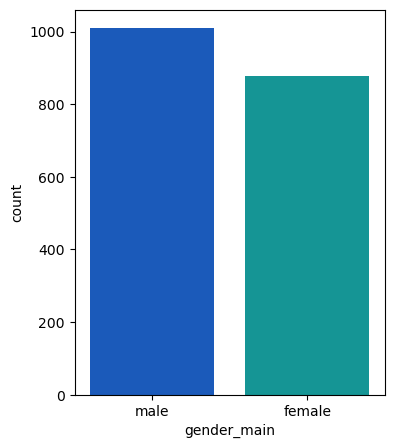

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def gender_plot(df):
    plt.figure(figsize=(4,5))
    sns.countplot(data =df, x='gender_main',palette='winter')


#Plot the proportion of male and female artists in our dataset

gender_plot(full_song_df)

## **Export our data of song names and artists to CSV for future use**

In [8]:
full_song_df.to_csv('full_song_list.csv',index=False)

## ---------

## **Import our CSV of artists and songs**

In [19]:
data_song = pd.read_csv('full_song_list.csv')

data_song = data_song.iloc[:,1:]

data_song

,gender_main,song_name,artist_id,main_artist,feat_artist,feat_artist2,gender_feat,gender_feat2,same_gender
0,male,Thinking out Loud,6eUKZXaKkcviH0Ku9w2n3V,ed sheeran,NaN,NaN,NaN,NaN,1
1,male,Lego House,6eUKZXaKkcviH0Ku9w2n3V,ed sheeran,NaN,NaN,NaN,NaN,1
2,male,The A Team,6eUKZXaKkcviH0Ku9w2n3V,ed sheeran,NaN,NaN,NaN,NaN,1
3,male,This Love,04gDigrS5kc9YWfZHwBETP,maroon 5,NaN,NaN,NaN,NaN,1
4,male,The Real Slim Shady,7dGJo4pcD2V6oG8kP0tJRR,eminem,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
1879,female,Physical,6M2wZ9GZgrQXHCFfjv46we,dua lipa,NaN,NaN,NaN,NaN,1
1880,female,Rain On Me,"1HY2Jd0NmPuamShAr6KMms, 66CXWjxzNUsdJxJ2JdwvnR",lady gaga,ariana grande,NaN,female,NaN,1
1881,female,Say So,5cj0lLjcoR7YOSnhnX0Po5,doja cat,NaN,NaN,NaN,NaN,1
1882,female,Dandelions,2WzaAvm2bBCf4pEhyuDgCY,ruth b.,NaN,NaN,NaN,NaN,1


In [24]:
#remove null values

data_song_nonan = data_song.loc[data_song['song_name'].notna()]

,gender_main,song_name,artist_id,main_artist,feat_artist,feat_artist2,gender_feat,gender_feat2,same_gender
0,male,Thinking out Loud,6eUKZXaKkcviH0Ku9w2n3V,ed sheeran,NaN,NaN,NaN,NaN,1
1,male,Lego House,6eUKZXaKkcviH0Ku9w2n3V,ed sheeran,NaN,NaN,NaN,NaN,1
2,male,The A Team,6eUKZXaKkcviH0Ku9w2n3V,ed sheeran,NaN,NaN,NaN,NaN,1
3,male,This Love,04gDigrS5kc9YWfZHwBETP,maroon 5,NaN,NaN,NaN,NaN,1
4,male,The Real Slim Shady,7dGJo4pcD2V6oG8kP0tJRR,eminem,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
1879,female,Physical,6M2wZ9GZgrQXHCFfjv46we,dua lipa,NaN,NaN,NaN,NaN,1
1880,female,Rain On Me,"1HY2Jd0NmPuamShAr6KMms, 66CXWjxzNUsdJxJ2JdwvnR",lady gaga,ariana grande,NaN,female,NaN,1
1881,female,Say So,5cj0lLjcoR7YOSnhnX0Po5,doja cat,NaN,NaN,NaN,NaN,1
1882,female,Dandelions,2WzaAvm2bBCf4pEhyuDgCY,ruth b.,NaN,NaN,NaN,NaN,1


## **Fetch lyrics using the Genius API**

In [25]:
data_lyrics = fetch_lyrics_list(data_song_nonan)

Searching for "Thinking out Loud" by ed sheeran...
Done.
Searching for "Lego House" by ed sheeran...
Done.
Searching for "The A Team" by ed sheeran...
Done.
Searching for "This Love" by maroon 5...
Done.
Searching for "The Real Slim Shady" by eminem...
Done.
Searching for "Lose Yourself" by eminem...
Searching for "Lose Yourself" by eminem...
Searching for "Lose Yourself" by eminem...
Searching for "Clocks" by coldplay...
Done.
Searching for "Yellow" by coldplay...
Done.
Searching for "The Scientist" by coldplay...
Done.
Searching for "Viva La Vida" by coldplay...
Done.
Searching for "Just the Way You Are" by bruno mars...
Done.
Searching for "Locked out of Heaven" by bruno mars...
Done.
Searching for "Gold Digger" by kanye west...
Done.
Searching for "Bohemian Rhapsody" by queen...
Done.
Searching for "Another One Bites The Dust" by queen...
Done.
Searching for "We Will Rock You" by queen...
Done.
Searching for "Killer Queen" by queen...
Done.
Searching for "I Want To Break Free" by q

## **Convert list of lyrics to dataframe with gender feature**

In [42]:
df_to_predict = to_final_df(data_lyrics,data_song)

df_to_predict.dropna(inplace=True)

# Export to CSV for future use

df_to_predict.to_csv('csv_to_predict.csv')

/var/folders/0w/_3f7b4n504s27w7d4x4_w41c0000gn/T/ipykernel_32999/1859884065.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['gender'] = df_predict['gender_main'].apply(lambda x : 1 if x == 'male' else 0)
